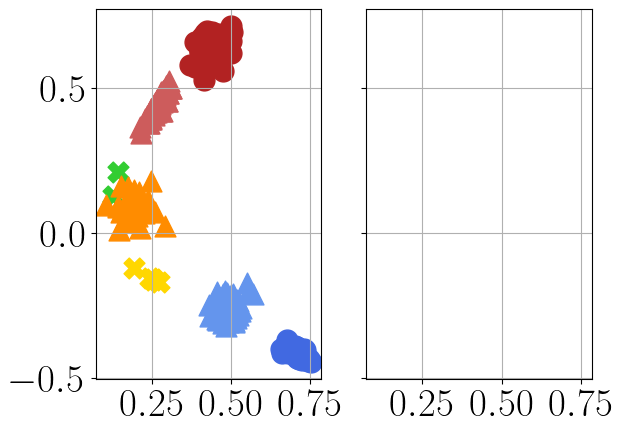

In [90]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Jul  3 18:05:45 2020

@author: flarroca
"""

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from graspologic import simulations, embed
# import ase_opt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


plt.close(fig='all')
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 28
plt.rcParams['lines.markersize'] = 15
plt.rcParams['axes.grid'] = True

#import netgraph




##############################
## Directed SBM - simula bipartidismo
##############################

plt.close(fig='all')

def grafo_senadores(nrep = 50, ndem = 50, no_presentes=[],
                    lrep = 50, ldem = 200, lmix = 40, 
                    p_rep_rep = 0.9, p_rep_dem = 0.01, p_rep_mix = 0.2, 
                    p_dem_rep = 0.1, p_dem_dem = 0.8, p_dem_mix = 0.3):
    """
    Genera un grafo con senadores democratas y republicanos. Es un SBM directivo
    con probabilidades de votacion indicadas en cada parametro. Las leyes mix 
    son leyes que tienden a votar en ambos partidos. 
    """
    
    n = [nrep, ndem, lrep, ldem, lmix]
    nodes_dict = {}
    labels_dict = {}
    markers_dict = {}
    
    for rep in range(nrep):
        nodes_dict[rep] = 0
        labels_dict[rep] = 'Party 1'
        markers_dict[rep] = 'o'
    for dem in range(ndem):
        nodes_dict[(dem+nrep)] = 9
        labels_dict[(dem+nrep)] = 'Party 2'
        markers_dict[(dem+nrep)] = 'o'
    for lr in range(lrep):
        nodes_dict[(ndem+nrep+lr)] = 3
        labels_dict[(ndem+nrep+lr)] = 'Laws party 1'
        markers_dict[(ndem+nrep+lr)] = '^'
    for ld in range(ldem):
        nodes_dict[(ndem+nrep+lrep+ld)] = 7
        labels_dict[(ndem+nrep+lrep+ld)] = 'Laws party 2'
        markers_dict[(ndem+nrep+lrep+ld)] = '^'
    for lm in range(lmix):
        nodes_dict[(ndem+nrep+lrep+ldem+lm)] = 5
        labels_dict[(ndem+nrep+lrep+ldem+lm)] = 'Mixed laws'
        markers_dict[(ndem+nrep+lrep+ldem+lm)] = '^'
    
    if no_presentes:
        for sen in no_presentes:
            markers_dict[sen] = 'P'
            labels_dict[sen] = 'Not present (' + labels_dict[sen] + ')'
            nodes_dict[sen] = nodes_dict[sen] - 1
            
    
    # p = [[0, 0, p_rep_rep, p_rep_dem, p_rep_mix],
    #      [0, 0, p_dem_rep, p_dem_dem, p_dem_mix],
    #     [0, 0, 0, 0, 0], # las leyes no votan
    #       [0, 0, 0, 0, 0], 
    #       [0, 0, 0, 0, 0]]
    p = [[0, 0, p_rep_rep, p_rep_dem, p_rep_mix],
         [0, 0, p_dem_rep, p_dem_dem, p_dem_mix],
         [p_rep_rep, p_dem_rep, 0, 0, 0], # las leyes no votan
         [p_rep_dem, p_dem_dem, 0, 0, 0], 
         [p_rep_mix, p_dem_mix, 0, 0, 0]]
    
    
    
    weights = simulations.sbm(n=n, p=p, directed=False)
    # gy.plot.heatmap(weights)
    g = nx.from_numpy_array(weights)
    
    nx.set_node_attributes(g, nodes_dict,'category')
    nx.set_node_attributes(g, labels_dict,'text_labels')
    #nx.set_node_attributes(g, markers_dict,'scatter_marker')
    return (g, weights)

# I generate the original graph
# Some senators did not vote on certain laws
nrep = 50
ndem = 50
num_senadores = nrep + ndem
lrep = 100
ldem = 100
lmix = 30
num_leyes = lrep + ldem + lmix
num_senadores_no_presentes_rep = 5
num_senadores_no_presentes_dem = 2
senadores_no_presentes = list(range(num_senadores_no_presentes_rep)) + list(range(ndem,ndem+num_senadores_no_presentes_dem))
(g1, weights) = grafo_senadores(nrep=nrep, ndem=ndem, lrep=lrep, ldem=ldem, lmix=lmix,no_presentes=senadores_no_presentes)

presentes = np.ones_like(weights)
proba_presente = 0.3
for sen in senadores_no_presentes:
    votos = [np.random.rand(1,weights.shape[0])<proba_presente]
    presentes[sen,:] = presentes[sen,:]*votos
    presentes[:,sen] = presentes[sen,:]*votos
# presentes = np.triu(presentes)

# I'll take that as a no
weights = weights*presentes
# weights = weights + weights.T

# Embedding with graspologic
ase = embed.AdjacencySpectralEmbed(n_elbows = 2, diag_aug=True)
Xhat1 = ase.fit_transform(weights)


fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2,sharex=True,sharey=True)

dims=[1,3]
ax1.scatter(Xhat1[num_senadores_no_presentes_rep:nrep,dims[0]-1],Xhat1[num_senadores_no_presentes_rep:nrep,dims[1]-1],c='royalblue',marker='o',label='Party 1')
ax1.scatter(Xhat1[:num_senadores_no_presentes_rep,dims[0]-1],Xhat1[:num_senadores_no_presentes_rep,dims[1]-1],c='gold',marker='X',label='Not present (Party 1)')
ax1.scatter(Xhat1[nrep+num_senadores_no_presentes_dem:num_senadores,dims[0]-1],Xhat1[nrep+num_senadores_no_presentes_dem:num_senadores,dims[1]-1],c='firebrick',marker='o',label='Party 2')
ax1.scatter(Xhat1[nrep:nrep+num_senadores_no_presentes_dem,dims[0]-1],Xhat1[nrep:nrep+num_senadores_no_presentes_dem,dims[1]-1],c='limegreen',marker='X',label='Not present (Party 2)')
ax1.scatter(Xhat1[num_senadores:num_senadores+lrep,dims[0]-1],Xhat1[num_senadores:num_senadores+lrep,dims[1]-1],c='cornflowerblue',marker='^',label='Party 1 laws')
ax1.scatter(Xhat1[num_senadores+lrep:num_senadores+lrep+ldem,dims[0]-1],Xhat1[num_senadores+lrep:num_senadores+lrep+ldem,dims[1]-1],c='indianred',marker='^',label='Party 2 laws')
ax1.scatter(Xhat1[num_senadores+lrep+ldem:,dims[0]-1],Xhat1[num_senadores+lrep+ldem:,dims[1]-1],c='darkorange',marker='^',label='Bipartisan laws')


# # Embedding with gradient descent, starting from the one obtained with graspologic
# nt = Xhat1.shape[0]
# #I'll consider only present voters
# M = (np.ones(nt) - np.eye(nt))*(presentes+presentes.T)
# Q = np.diag((-1)**np.arange(Xhat1.shape[1]))
# X_gd = ase_opt.ase_gd_GRPDG(weights,Xhat1,Q,M)

# ax2.scatter(X_gd[num_senadores_no_presentes_rep:nrep,dims[0]-1],X_gd[num_senadores_no_presentes_rep:nrep,dims[1]-1],c='royalblue',marker='o',label='Party 1 members')
# ax2.scatter(X_gd[:num_senadores_no_presentes_rep,dims[0]-1],X_gd[:num_senadores_no_presentes_rep,dims[1]-1],c='gold',marker='X',label='Missing data (Party 1)')
# ax2.scatter(X_gd[nrep+num_senadores_no_presentes_dem:num_senadores,dims[0]-1],X_gd[nrep+num_senadores_no_presentes_dem:num_senadores,dims[1]-1],c='firebrick',marker='o',label='Party 2 members')
# ax2.scatter(X_gd[nrep:nrep+num_senadores_no_presentes_dem,dims[0]-1],X_gd[nrep:nrep+num_senadores_no_presentes_dem,dims[1]-1],c='limegreen',marker='X',label='Missing data (Party 2)')
# ax2.scatter(X_gd[num_senadores:num_senadores+lrep,dims[0]-1],X_gd[num_senadores:num_senadores+lrep,dims[1]-1],c='cornflowerblue',marker='^',label='Party 1 laws')
# ax2.scatter(X_gd[num_senadores+lrep:num_senadores+lrep+ldem,dims[0]-1],X_gd[num_senadores+lrep:num_senadores+lrep+ldem,dims[1]-1],c='indianred',marker='^',label='Party 2 laws')
# ax2.scatter(X_gd[num_senadores+lrep+ldem:,dims[0]-1],X_gd[num_senadores+lrep+ldem:,dims[1]-1],c='darkorange',marker='^',label='Bipartisan laws')


# plt.legend(loc='upper center', bbox_to_anchor=(-0.05, -0.05),fancybox=True, shadow=True, ncol=4, fontsize=36, handletextpad=0.01,columnspacing=0.5,borderpad=0.1)
# fig.subplots_adjust(left=0.06,right=0.98,top=0.97,bottom=0.24,hspace=0.06,wspace=0.02)

# #
# # PCA for visualization
# X_all = np.vstack((Xhat1,X_gd))
# Xtsne = PCA(n_components=2).fit_transform(X_all)
# Xtsne_gp,Xtsne_gd = np.split(Xtsne,2)
# #Xtsne_gp = TSNE(n_components=2).fit_transform(Xhat1)
# #Xtsne_gd = TSNE(n_components=2).fit_transform(X_gd)
#
# fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1,sharex=True,sharey=True)
#
# dims=[1,2]
# ax1.scatter(Xtsne_gp[num_senadores_no_presentes_rep:nrep,dims[0]-1],Xtsne_gp[num_senadores_no_presentes_rep:nrep,dims[1]-1],c='royalblue',marker='o',label='Party 1')
# ax1.scatter(Xtsne_gp[:num_senadores_no_presentes_rep,dims[0]-1],Xtsne_gp[:num_senadores_no_presentes_rep,dims[1]-1],c='gold',marker='X',label='Not present (Party 1)')
# ax1.scatter(Xtsne_gp[nrep+num_senadores_no_presentes_dem:num_senadores,dims[0]-1],Xtsne_gp[nrep+num_senadores_no_presentes_dem:num_senadores,dims[1]-1],c='firebrick',marker='o',label='Party 2')
# ax1.scatter(Xtsne_gp[nrep:nrep+num_senadores_no_presentes_dem,dims[0]-1],Xtsne_gp[nrep:nrep+num_senadores_no_presentes_dem,dims[1]-1],c='limegreen',marker='X',label='Not present (Party 2)')
# ax1.scatter(Xtsne_gp[num_senadores:num_senadores+lrep,dims[0]-1],Xtsne_gp[num_senadores:num_senadores+lrep,dims[1]-1],c='cornflowerblue',marker='^',label='Party 1 laws')
# ax1.scatter(Xtsne_gp[num_senadores+lrep:num_senadores+lrep+ldem,dims[0]-1],Xtsne_gp[num_senadores+lrep:num_senadores+lrep+ldem,dims[1]-1],c='indianred',marker='^',label='Party 2 laws')
# ax1.scatter(Xtsne_gp[num_senadores+lrep+ldem:,dims[0]-1],Xtsne_gp[num_senadores+lrep+ldem:,dims[1]-1],c='darkorange',marker='^',label='Bipartisan laws')
#
# ax2.scatter(Xtsne_gd[num_senadores_no_presentes_rep:nrep,dims[0]-1],Xtsne_gd[num_senadores_no_presentes_rep:nrep,dims[1]-1],c='royalblue',marker='o',label='Party 1 members')
# ax2.scatter(Xtsne_gd[:num_senadores_no_presentes_rep,dims[0]-1],Xtsne_gd[:num_senadores_no_presentes_rep,dims[1]-1],c='gold',marker='X',label='Missing data (Party 1)')
# ax2.scatter(Xtsne_gd[nrep+num_senadores_no_presentes_dem:num_senadores,dims[0]-1],Xtsne_gd[nrep+num_senadores_no_presentes_dem:num_senadores,dims[1]-1],c='firebrick',marker='o',label='Party 2 members')
# ax2.scatter(Xtsne_gd[nrep:nrep+num_senadores_no_presentes_dem,dims[0]-1],Xtsne_gd[nrep:nrep+num_senadores_no_presentes_dem,dims[1]-1],c='limegreen',marker='X',label='Missing data (Party 2)')
# ax2.scatter(Xtsne_gd[num_senadores:num_senadores+lrep,dims[0]-1],Xtsne_gd[num_senadores:num_senadores+lrep,dims[1]-1],c='cornflowerblue',marker='^',label='Party 1 laws')
# ax2.scatter(Xtsne_gd[num_senadores+lrep:num_senadores+lrep+ldem,dims[0]-1],Xtsne_gd[num_senadores+lrep:num_senadores+lrep+ldem,dims[1]-1],c='indianred',marker='^',label='Party 2 laws')
# ax2.scatter(Xtsne_gd[num_senadores+lrep+ldem:,dims[0]-1],Xtsne_gd[num_senadores+lrep+ldem:,dims[1]-1],c='darkorange',marker='^',label='Bipartisan laws')
#
#
# plt.legend(loc='upper center', bbox_to_anchor=(0.48, -0.07),fancybox=True, shadow=True, ncol=4)
# plt.suptitle('PCA')
# fig.subplots_adjust(left=0.07,right=0.98,top=0.93,bottom=0.20,hspace=0.06)
#
# # t-distributed stochastic neighbor embedding for visualization
# X_all = np.vstack((Xhat1,X_gd))
# Xtsne = TSNE(n_components=2).fit_transform(X_all)
# Xtsne_gp,Xtsne_gd = np.split(Xtsne,2)
# #Xtsne_gp = TSNE(n_components=2).fit_transform(Xhat1)
# #Xtsne_gd = TSNE(n_components=2).fit_transform(X_gd)
#
# fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1,sharex=True,sharey=True)
#
# dims=[1,2]

# ax1.scatter(Xtsne_gp[num_senadores_no_presentes_rep:nrep,dims[0]-1],Xtsne_gp[num_senadores_no_presentes_rep:nrep,dims[1]-1],c='royalblue',marker='o',label='Party 1')
# ax1.scatter(Xtsne_gp[:num_senadores_no_presentes_rep,dims[0]-1],Xtsne_gp[:num_senadores_no_presentes_rep,dims[1]-1],c='gold',marker='X',label='Not present (Party 1)')
# ax1.scatter(Xtsne_gp[nrep+num_senadores_no_presentes_dem:num_senadores,dims[0]-1],Xtsne_gp[nrep+num_senadores_no_presentes_dem:num_senadores,dims[1]-1],c='firebrick',marker='o',label='Party 2')
# ax1.scatter(Xtsne_gp[nrep:nrep+num_senadores_no_presentes_dem,dims[0]-1],Xtsne_gp[nrep:nrep+num_senadores_no_presentes_dem,dims[1]-1],c='limegreen',marker='X',label='Not present (Party 2)')
# ax1.scatter(Xtsne_gp[num_senadores:num_senadores+lrep,dims[0]-1],Xtsne_gp[num_senadores:num_senadores+lrep,dims[1]-1],c='cornflowerblue',marker='^',label='Party 1 laws')
# ax1.scatter(Xtsne_gp[num_senadores+lrep:num_senadores+lrep+ldem,dims[0]-1],Xtsne_gp[num_senadores+lrep:num_senadores+lrep+ldem,dims[1]-1],c='indianred',marker='^',label='Party 2 laws')
# ax1.scatter(Xtsne_gp[num_senadores+lrep+ldem:,dims[0]-1],Xtsne_gp[num_senadores+lrep+ldem:,dims[1]-1],c='darkorange',marker='^',label='Bipartisan laws')
#
# ax2.scatter(Xtsne_gd[num_senadores_no_presentes_rep:nrep,dims[0]-1],Xtsne_gd[num_senadores_no_presentes_rep:nrep,dims[1]-1],c='royalblue',marker='o',label='Party 1 members')
# ax2.scatter(Xtsne_gd[:num_senadores_no_presentes_rep,dims[0]-1],Xtsne_gd[:num_senadores_no_presentes_rep,dims[1]-1],c='gold',marker='X',label='Missing data (Party 1)')
# ax2.scatter(Xtsne_gd[nrep+num_senadores_no_presentes_dem:num_senadores,dims[0]-1],Xtsne_gd[nrep+num_senadores_no_presentes_dem:num_senadores,dims[1]-1],c='firebrick',marker='o',label='Party 2 members')
# ax2.scatter(Xtsne_gd[nrep:nrep+num_senadores_no_presentes_dem,dims[0]-1],Xtsne_gd[nrep:nrep+num_senadores_no_presentes_dem,dims[1]-1],c='limegreen',marker='X',label='Missing data (Party 2)')
# ax2.scatter(Xtsne_gd[num_senadores:num_senadores+lrep,dims[0]-1],Xtsne_gd[num_senadores:num_senadores+lrep,dims[1]-1],c='cornflowerblue',marker='^',label='Party 1 laws')
# ax2.scatter(Xtsne_gd[num_senadores+lrep:num_senadores+lrep+ldem,dims[0]-1],Xtsne_gd[num_senadores+lrep:num_senadores+lrep+ldem,dims[1]-1],c='indianred',marker='^',label='Party 2 laws')
# ax2.scatter(Xtsne_gd[num_senadores+lrep+ldem:,dims[0]-1],Xtsne_gd[num_senadores+lrep+ldem:,dims[1]-1],c='darkorange',marker='^',label='Bipartisan laws')
#
#
# plt.legend(loc='upper center', bbox_to_anchor=(0.48, -0.07),fancybox=True, shadow=True, ncol=4)
# plt.suptitle('t-SNE')
# fig.subplots_adjust(left=0.07,right=0.98,top=0.93,bottom=0.20,hspace=0.06)

plt.show()

In [126]:
Q = np.diag((-1)**np.arange(Xhat1.shape[1]))
Q

array([[ 1,  0,  0,  0,  0],
       [ 0, -1,  0,  0,  0],
       [ 0,  0,  1,  0,  0],
       [ 0,  0,  0, -1,  0],
       [ 0,  0,  0,  0,  1]])

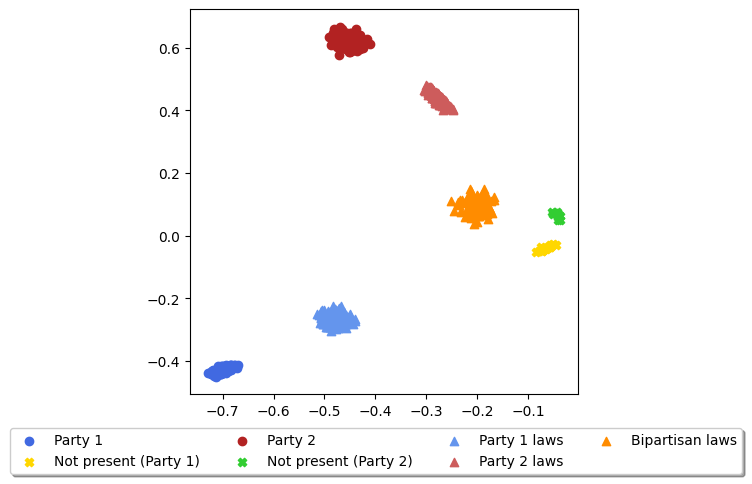

In [11]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.utils import stochastic_blockmodel_graph, to_dense_adj, erdos_renyi_graph
from graspologic.embed import AdjacencySpectralEmbed 

## BIPARTITE
d = 5
n_P1 = 250
n_P2 = 250
n_L1 = 500
n_L2 = 500
n_L3 = 150

P1_L1 = 0.9
P1_L2 = 0.01
P1_L3 = 0.2  
P2_L1 = 0.1
P2_L2 = 0.8
P2_L3 = 0.3


p = [
    [0, 0, P1_L1, P1_L2, P1_L3],
    [0, 0, P2_L1, P2_L2, P2_L3],
    [P1_L1, P2_L1, 0, 0, 0], 
    [P1_L2, P2_L2, 0, 0, 0], 
    [P1_L3, P2_L3, 0, 0, 0]
    ]

n = [n_P1, n_P2, n_L1, n_L2, n_L3]
num_nodes = np.sum(n)

edge_index = stochastic_blockmodel_graph(n, p)

n_P1_np = 25
n_P2_np = 10
senadores_no_presentes = list(range(n_P1_np)) + list(range(n_P1,n_P1+n_P2_np))

mask = torch.ones([num_nodes,num_nodes]).squeeze(0)
for i in senadores_no_presentes:
    votos = (torch.rand(1, num_nodes) < 0.1).int()
    mask[i,:] = votos
    mask[:,i] = votos



adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0).numpy()
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
masked_adj = adj_matrix*mask.numpy()
x_ase = ase.fit_transform(masked_adj)
x_ase = torch.from_numpy(x_ase)



plt.figure(figsize=(5,5))
plt.scatter(x_ase[n_P1_np:n_P1,0],x_ase[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
plt.scatter(x_ase[:n_P1_np,0],x_ase[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
plt.scatter(x_ase[n_P1+n_P2_np:n_P1+n_P2,0],x_ase[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
plt.scatter(x_ase[n_P1:n_P1+n_P2_np,0],x_ase[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
plt.scatter(x_ase[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_ase[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
plt.scatter(x_ase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_ase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
plt.scatter(x_ase[n_P1+n_P2+n_L1+n_L2:,0],x_ase[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
plt.legend(loc='upper center', bbox_to_anchor=(0.48, -0.07),fancybox=True, shadow=True, ncol=4)
plt.show()


In [12]:
A = to_dense_adj(edge_index.to('cpu'), max_num_nodes=num_nodes).squeeze(0)

u, V = torch.linalg.eig(A)

list_q=[]
for i in range(d):
    if u[i].numpy()>0:
        list_q.append(1)
    else:
        list_q.append(-1)
list_q.sort(reverse=True)
q = torch.Tensor(list_q)
q

tensor([ 1.,  1., -1., -1., -1.])

Iteraciones:  43


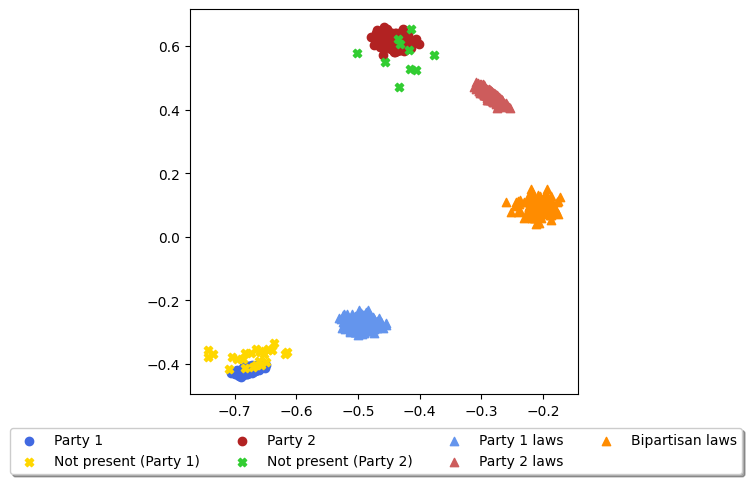

In [19]:
import sys
sys.path.append("../")

from models.RDPG_GD import GRDPG_GD_Armijo
import math
from training.get_init import get_x_init
from models.SVD_truncate import align_Xs


Q=torch.diag(q)
x  = get_x_init(num_nodes, d, 0, math.pi/2, 0, math.pi/2)
x_grdpg, cost, k  = GRDPG_GD_Armijo(x_ase, edge_index, Q, mask.nonzero().t().contiguous())
x_grdpg = x_grdpg.detach()
print("Iteraciones: ", k)



x_grdpg = align_Xs(x_grdpg,x_ase)
# x_cgd_p = align_Xs(x_cgd,x_svd)
# x_gd_p = align_Xs(x_gd,x_svd)
# x_gd_5_p = align_Xs(x_gd_5,x_svd)


plt.figure(figsize=(5,5))
plt.scatter(x_grdpg[n_P1_np:n_P1,0],x_grdpg[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
plt.scatter(x_grdpg[:n_P1_np,0],x_grdpg[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
plt.scatter(x_grdpg[n_P1+n_P2_np:n_P1+n_P2,0],x_grdpg[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
plt.scatter(x_grdpg[n_P1:n_P1+n_P2_np,0],x_grdpg[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
plt.scatter(x_grdpg[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_grdpg[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
plt.scatter(x_grdpg[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_grdpg[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
plt.scatter(x_grdpg[n_P1+n_P2+n_L1+n_L2:,0],x_grdpg[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
plt.legend(loc='upper center', bbox_to_anchor=(0.48, -0.07),fancybox=True, shadow=True, ncol=4)
plt.show()

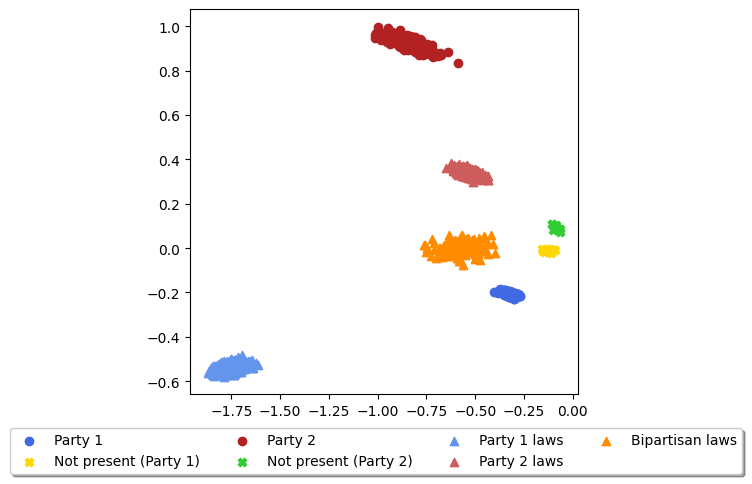

In [25]:
import sys
sys.path.append("../")

from models.GLASE_unshared_normalized import gLASE 
import math
from training.get_init import get_x_init
from models.SVD_truncate import align_Xs


Q=torch.diag(q)
gd_steps=5

edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous()

glase = gLASE(d, d, gd_steps)
glase.load_state_dict(torch.load('../saved_models/lase_unshared_normalized_unbalanced_bipartite_xase.pt'))
glase.eval()

x_glase = glase(x_ase, edge_index, edge_index_2, Q, mask.nonzero().t().contiguous())
x_glase = x_glase.detach()



x_glase = align_Xs(x_glase,x_ase)
# x_cgd_p = align_Xs(x_cgd,x_svd)
# x_gd_p = align_Xs(x_gd,x_svd)
# x_gd_5_p = align_Xs(x_gd_5,x_svd)


plt.figure(figsize=(5,5))
plt.scatter(x_glase[n_P1_np:n_P1,0],x_glase[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
plt.scatter(x_glase[:n_P1_np,0],x_glase[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
plt.scatter(x_glase[n_P1+n_P2_np:n_P1+n_P2,0],x_glase[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
plt.scatter(x_glase[n_P1:n_P1+n_P2_np,0],x_glase[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
plt.scatter(x_glase[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_glase[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
plt.scatter(x_glase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_glase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
plt.scatter(x_glase[n_P1+n_P2+n_L1+n_L2:,0],x_glase[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
plt.legend(loc='upper center', bbox_to_anchor=(0.48, -0.07),fancybox=True, shadow=True, ncol=4)
plt.show()